In [499]:
import math
import random
import time
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

# 贈与と社会構造

板尾健司による以下の記事の一部を再現した。

[贈与によって「社会の格差」が作り出されていた…数学が明らかにした権力構造が生まれる仕組み](https://gendai.media/articles/-/144975)

記事の元になっている論文はこちら。
* [Transition of social organisations driven by gift relationships](https://www.nature.com/articles/s41599-023-01688-w)

In [500]:
def gini(x, w=None):
    # ジニ係数を求める
    x = np.asarray(x)
    if w is not None:
        w = np.asarray(w)
        sorted_indices = np.argsort(x)
        sorted_x = x[sorted_indices]
        sorted_w = w[sorted_indices]
        # Force float dtype to avoid overflows
        cumw = np.cumsum(sorted_w, dtype=float)
        cumxw = np.cumsum(sorted_x * sorted_w, dtype=float)
        return (np.sum(cumxw[1:] * cumw[:-1] - cumxw[:-1] * cumw[1:]) / 
                (cumxw[-1] * cumw[-1]))
    else:
        sorted_x = np.sort(x)
        n = len(x)
        cumx = np.cumsum(sorted_x, dtype=float)
        # The above formula, with all weights equal to 1 simplifies to:
        return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

In [501]:
N = 100 # 個人数
eta = 0.03 # 取り引きによるエッジの重みの増加係数
r = 0.1 # 返礼の利子率

w = np.ones(N) # 資産
p = (np.ones(N) - np.eye(N)) / (N-1) # i から j へ向かうエッジの重み

# 誰にいくら借りがあるかを記録する list
# debt[i] は i の借金の相手と額の dict。
# key = 人、value = 借金の額
debt = [dict() for i in range(N)]

# ステップごとの富と名声のジニ係数
gini_w = []
gini_c = []

# ステップごとの富の合計
total_w = []

num_iter = 0

In [ ]:
"""
# 誰にいくら借りがあるかを記録する list
# debt[i] は人 #i の借金情報を保持する deque。
# deque の要素は (j, amount) というタプルで、j は借金の相手、amount は借金の額。
debt = [deque() for i in range(N)]

# debt が FIFO キューで、同じ人にでも借金を返すたびにエッジの重さを増す。
def transact_pbsolete():
    global w, p, debt
    global gini_w, gini_c, total_w
    global t1, t2, t3, t4
    delta_p = np.zeros((N, N))
    
    # 1. 贈与
    #print('贈与')
    start = time.perf_counter()
    delta_w = np.zeros(N)
    new_debt = []
    for i in range(N):
        #print(f'  {i}: ', end='')
        if w[i] > 0 and len(debt[i]) == 0: # 借金がなく財産があれば、贈与する
            j = random.choices(range(N), weights=p[i])[0] # エッジの重みに応じて相手を選ぶ
            delta_w[j] += w[i] # i -> j の贈与
            #print(f'{w[i]}円->{j}', end='')
            delta_p[i, j] += eta # i -> j のエッジの重みを増やす
            new_debt.append((j, i, w[i] * (1 + r))) # j の i への借金を記憶する
            w[i] = 0
        #print('')
    # 新たにできた借金を debt に追加する
    for j, i, amount in new_debt:
        debt[j].append((i, amount))
    # 全員の贈与額が確定してから、残りの財産に贈与額を足す。
    w += delta_w
    #print(f'  贈与後の財産: {w}')
    t1 += (time.perf_counter() - start)
    
    # 2. 蓄財
    #print('蓄財')
    start = time.perf_counter()
    for i in range(N):
        w[i] += (1 + math.log(1 + w[i])) / 100
    #print(f'  蓄財後の財産: {w}')
    t2 += (time.perf_counter() - start)
    
    # 3. 返礼
    #print('返礼')
    delta_w = np.zeros(N)
    start = time.perf_counter()
    for i in range(N):
        #print(f'  {i}: ', end='')
        while w[i] > 0 and len(debt[i]) > 0: # 財産が残っている限り返礼する
            j, amount = debt[i][0]
            if w[i] < amount: # 返済額に足りない...
                #print(f'{w[i]}円->{j} ', end='')
                delta_w[j] += w[i]
                debt[i][0] = (j, amount - w[i]) # 借金は減ったが残っている
                w[i] = 0
            else:
                #print(f'{amount}円->{j} ', end='')
                debt[i].popleft() # この借金は払い切った
                delta_w[j] += amount
                w[i] -= amount
            delta_p[i, j] += eta # i -> j のエッジの重みを増やす
        #print(f'返済後の借金: {list(debt[i])}') # list 化に時間がかかるので注意！
    t3 += (time.perf_counter() - start)
    # 返済額がすべて確定してから、残りの財産に返済額を足す。
    # つまり、返済金で返済はしない。
    w += delta_w
    #print(f'  返礼後の財産: {w}')

    # 4. 後処理
    start = time.perf_counter()
    # p を更新
    p += delta_p
    # p を正規化
    p = p / p.sum(axis=1)[:, np.newaxis]
    #print(f'エッジの重み: {p}')
    c = p.sum(axis=0) # 名声
    #print(f'名声: {c}')
    #print(f'富のジニ係数: {gini(w)}')
    #print(f'名声のジニ係数: {gini(c)}')
    gini_w.append(gini(w))
    gini_c.append(gini(c))
    total_w.append(w.sum())
    t4 += (time.perf_counter() - start)
"""

In [502]:
def transact():
    """
    debt が dict で、同じ人への借金はまとめて返す。
    """
    global w, p, debt
    global gini_w, gini_c, total_w
    global t1, t2, t3, t4
    delta_p = np.zeros((N, N))
    
    # 1. 贈与
    #print('贈与')
    start = time.perf_counter()
    delta_w = np.zeros(N)
    new_debt = []
    for i in range(N):
        #print(f'  {i}: ', end='')
        if w[i] > 0 and len(debt[i]) == 0: # 借金がなく財産があれば、贈与する
            j = random.choices(range(N), weights=p[i])[0] # エッジの重みに応じて相手を選ぶ
            delta_w[j] += w[i] # i -> j の贈与
            #print(f'{w[i]}円->{j}', end='')
            delta_p[i, j] += eta # i -> j のエッジの重みを増やす
            new_debt.append((j, i, w[i] * (1 + r))) # j に i が貸した借金を記憶する
            w[i] = 0
        #print('')
    # 新たにできた借金を debt に追加する
    for j, i, amount in new_debt:
        debt[j][i] = debt[j].get(i, 0) + amount
    # 全員の贈与額が確定してから、残りの財産に贈与額を足す。
    w += delta_w
    #print(f'  贈与後の財産: {w}')
    t1 += (time.perf_counter() - start)
    
    # 2. 蓄財
    #print('蓄財')
    start = time.perf_counter()
    for i in range(N):
        w[i] += (1 + math.log(1 + w[i])) / 100
    #print(f'  蓄財後の財産: {w}')
    t2 += (time.perf_counter() - start)
    
    # 3. 返礼
    #print('返礼')
    delta_w = np.zeros(N)
    start = time.perf_counter()
    for i in range(N):
        #print(f'  {i}: ', end='')
        while w[i] > 0 and len(debt[i]) > 0: # 財産が残っている限り返礼する
            j, amount = min(debt[i].items(), key=lambda x: x[1]) # 返済額が最小の借金を得る
            if w[i] < amount: # 返済額に足りない...
                #print(f'{w[i]}円->{j} ', end='')
                delta_w[j] += w[i]
                debt[i][j] -= w[i] # 借金は減ったが残っている
                w[i] = 0
            else:
                #print(f'{amount}円->{j} ', end='')
                del debt[i][j] # この借金は払い切った
                delta_w[j] += amount
                w[i] -= amount
            delta_p[i, j] += eta # i -> j のエッジの重みを増やす
        #print(f'返済後の借金: {debt[i]}')
    t3 += (time.perf_counter() - start)
    # 返済額がすべて確定してから、残りの財産に返済額を足す。
    # つまり、返済金で返済はしない。
    w += delta_w
    #print(f'  返礼後の財産: {w}')

    # 4. 後処理
    start = time.perf_counter()
    # p を更新
    p += delta_p
    # p を正規化
    p = p / p.sum(axis=1)[:, np.newaxis]
    #print(f'エッジの重み: {p}')
    c = p.sum(axis=0) # 名声
    #print(f'名声: {c}')
    #print(f'富のジニ係数: {gini(w)}')
    #print(f'名声のジニ係数: {gini(c)}')
    gini_w.append(gini(w))
    gini_c.append(gini(c))
    total_w.append(w.sum())
    t4 += (time.perf_counter() - start)

In [503]:
# 計算時間の計測
t1 = 0
t2 = 0
t3 = 0
t4 = 0

for i in range(100000):
    #print(f'取り引き {i}')
    transact()
    num_iter += 1
    #print('')

print(f'計算時間: {t1}, {t2}, {t3}, {t4}')
print(f'ステップ数: {num_iter}')

計算時間: 26.138663800957147, 3.4140808066003956, 8.05403489235323, 9.378265097737312
ステップ数: 100000


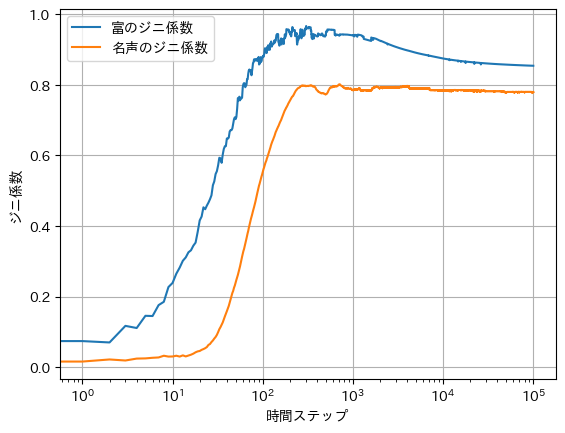

In [504]:
plt.plot(gini_w, label='富のジニ係数')
plt.plot(gini_c, label='名声のジニ係数')
plt.xscale("log")
plt.grid()
plt.xlabel("時間ステップ")
plt.ylabel("ジニ係数")
plt.legend()
plt.show()    

記事や論文にあるグラフと比較すると、
富のジニ係数の変化はおおむね一致している。

名声のジニ係数については、
100 ステップ後、記事では 0.1、論文では 0.3 程度なのに対して、ここでは 0.6 まで上がっている。

また、記事や論文では富のジニ係数も名声のジニ係数も単調に増加を続けていて、
富については 1.0、名声については 0.4（記事）や 0.75（論文）が水平漸化線になっているように見えるが、
本シミュレーションでは 200～500 ステップでジニ係数は最大となり、その後は少しずつ減少していく。

これらの違いがどこからくるのかは不明。

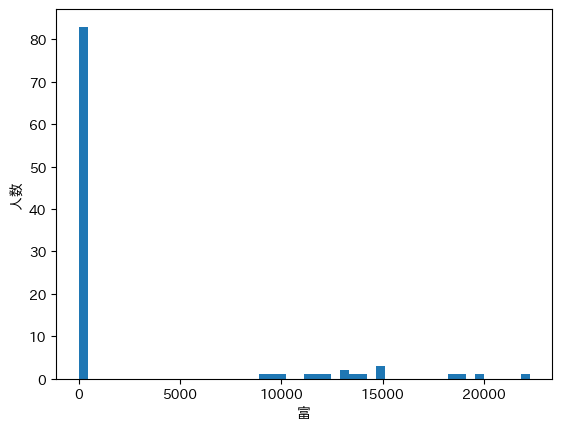

In [505]:
plt.hist(w, bins=50)
plt.xlabel("富")
plt.ylabel("人数")
plt.show()

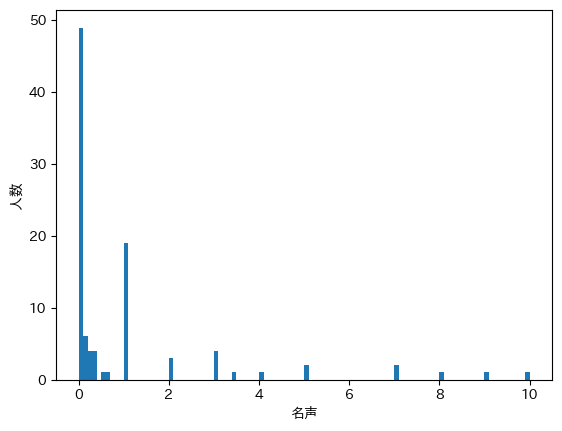

In [506]:
c = p.sum(axis=0) # 名声
plt.hist(c, bins=100)
plt.xlabel("名声")
plt.ylabel("人数")
plt.show()

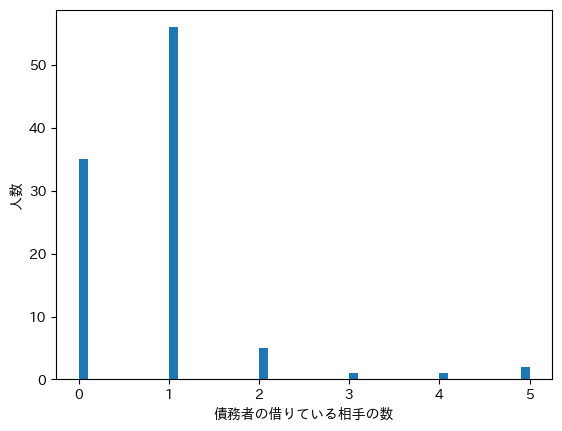

In [507]:
# 債務者の借金の件数（借りている相手の数）の分布
num_borrowing = [len(debt[i]) for i in range(N)]

plt.hist(num_borrowing, bins=50)
plt.xlabel("債務者の借りている相手の数")
plt.ylabel("人数")
plt.show()

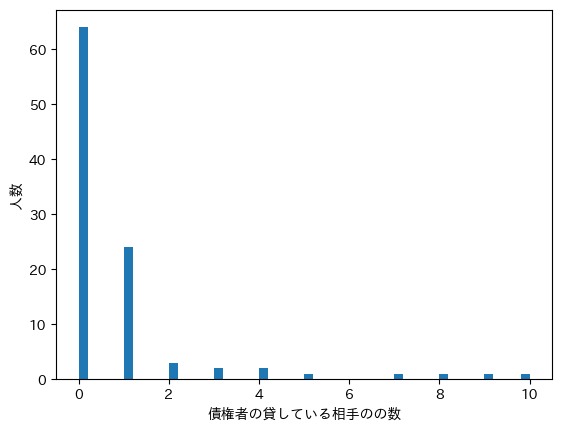

In [508]:
# 債権者の借金の件数（貸している相手の数）の分布
num_lending = np.zeros(N)
for dct in debt:
    for lender, amount in dct.items():
        num_lending[lender] += 1

plt.hist(num_lending, bins=50)
plt.xlabel("債権者の貸している相手のの数")
plt.ylabel("人数")
plt.show()

In [509]:
# 贈与の相手の固定化
for i in range(N):
    masters = np.where(p[i] > 1.0e-100)[0]
    print(f'{i}->{masters} 財産{w[i]:.2f} 名声{c[i]:.1f} 債権者:{list(debt[i].keys())}')

0->[71] 財産0.00 名声1.0 債権者:[71]
1->[10] 財産0.01 名声0.3 債権者:[]
2->[44] 財産0.00 名声1.0 債権者:[44]
3->[11] 財産0.00 名声0.0 債権者:[11]
4->[10] 財産0.01 名声0.3 債権者:[]
5->[84] 財産0.01 名声0.2 債権者:[]
6->[29] 財産0.00 名声0.0 債権者:[29]
7->[28] 財産0.00 名声0.0 債権者:[28]
8->[9] 財産0.00 名声0.0 債権者:[9]
9->[55] 財産13019.35 名声2.0 債権者:[]
10->[ 1  4 96] 財産0.00 名声3.0 債権者:[1, 96, 4]
11->[99] 財産14014.64 名声5.0 債権者:[]
12->[84] 財産0.01 名声0.2 債権者:[]
13->[44] 財産0.00 名声0.0 債権者:[44]
14->[28] 財産0.00 名声0.0 債権者:[28]
15->[16] 財産11283.73 名声2.0 債権者:[]
16->[15] 財産0.00 名声1.0 債権者:[15]
17->[97] 財産0.00 名声1.0 債権者:[97]
18->[29] 財産0.01 名声0.2 債権者:[]
19->[88] 財産0.00 名声1.0 債権者:[88, 87]
20->[73] 財産0.00 名声0.0 債権者:[73]
21->[85] 財産0.00 名声1.0 債権者:[85]
22->[44] 財産0.00 名声0.0 債権者:[44]
23->[11] 財産0.00 名声0.0 債権者:[11]
24->[79 81] 財産18607.73 名声9.0 債権者:[]
25->[97] 財産0.00 名声0.0 債権者:[97]
26->[74] 財産0.01 名声0.0 債権者:[]
27->[37] 財産0.00 名声1.0 債権者:[37, 40]
28->[69] 財産22241.44 名声10.0 債権者:[]
29->[18 35 36 86 95] 財産0.02 名声7.0 債権者:[35, 36, 86, 95, 18]
30->[73] 財産0.00 名声0.0 債権者:[73]
3

## まとめ

* 贈与の相手の固定化が見られる。

  固定化の形には数パターンが見られる。
  
  1. 二人の間で贈与、返礼を繰り返す
     - 71->[0] 財産9966.18 名声1.0 債権者:[]
     - 0->[71] 財産0.00 名声1.0 債権者:[71]
     
     この場合、一方は資産家で借金なし、もう一方は財産ゼロで債務者である。     
     
  2. 複数の債権者が一人の債務者にたかる
     - 1->[10] 財産0.01 名声0.3 債権者:[]
     - 4->[10] 財産0.01 名声0.3 債権者:[]
     - 96->[10] 財産12085.48 名声0.3 債権者:[]
     - 10->[ 1  4 96] 財産0.00 名声3.0 債権者:[1, 96, 4]

  3. 複数の債務者が一人の資産に貢ぐ
  
     その1
     - 3->[11] 財産0.00 名声0.0 債権者:[11]
     - 99->[11] 財産0.00 名声1.0 債権者:[11]
     - 11->[99] 財産14014.64 名声5.0 債権者:[]
     
     その2
     - 31->[24] 財産0.00 名声0.0 債権者:[24]
     - 46->[24] 財産0.00 名声0.0 債権者:[24]
     - 48->[24] 財産0.00 名声0.0 債権者:[24]
     - 50->[24] 財産0.00 名声0.0 債権者:[24]
     - 58->[24] 財産0.00 名声0.0 債権者:[24]
     - 79->[24] 財産0.00 名声0.7 債権者:[24]
     - 80->[24] 財産0.00 名声0.0 債権者:[24]
     - 81->[24] 財産0.00 名声0.3 債権者:[24]
     - 98->[24] 財産0.00 名声0.0 債権者:[24]
     - 24->[79 81] 財産18607.73 名声9.0 債権者:[]


* 名声の高いものには裕福な者が多いが、名声は高いのに財産ゼロの者もいる。

  逆に、名声が小さくても裕福な者もいる。
     - 36->[29] 財産15093.27 名声0.2 債権者:[]
    
  ただし、裕福な者は名声が常に非ゼロである。つまり、名声がゼロなら財産は常にほぼゼロ（最大で 0.01）。
